<a href="https://www.kaggle.com/dhruvgoel200113/dhruvgoel-102083029-ds-assign1?scriptVersionId=88774420" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#installing rapids
import sys
!cp ../input/rapids-library/rapids.21.06/opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

cp: missing destination file operand after '../input/rapids-library/rapids.21.06/opt/conda/envs/rapids.tar.gz'
Try 'cp --help' for more information.
tar (child): rapids.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory


## About the dataset

* **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
* **MSSubClass**: The building class
* **MSZoning**: The general zoning classification
* **LotFrontage**: Linear feet of street connected to property
* **LotArea**: Lot size in square feet
* **Street**: Type of road access
* **Alley**: Type of alley access
* **LotShape**: General shape of property
* **LandContour**: Flatness of the property
* **Utilities**: Type of utilities available
* **LotConfig**: Lot configuration
* **LandSlope**: Slope of property
* **Neighborhood**: Physical locations within Ames city limits
* **Condition1**: Proximity to main road or railroad
* **Condition2**: Proximity to main road or railroad (if a second is present)
* **BldgType**: Type of dwelling
* **HouseStyle**: Style of dwelling
* **OverallQual**: Overall material and finish quality
* **OverallCond**: Overall condition rating
* **YearBuilt**: Original construction date
* **YearRemodAdd**: Remodel date
* **RoofStyle**: Type of roof
* **RoofMatl**: Roof material
* **Exterior1st**: Exterior covering on house
* **Exterior2nd**: Exterior covering on house (if more than one material)
* **MasVnrType**: Masonry veneer type
* **MasVnrArea**: Masonry veneer area in square feet
* **ExterQual**: Exterior material quality
* **ExterCond**: Present condition of the material on the exterior
* **Foundation**: Type of foundation
* **BsmtQual**: Height of the basement
* **BsmtCond**: General condition of the basement
* **BsmtExposure**: Walkout or garden level basement walls
* **BsmtFinType1**: Quality of basement finished area
* **BsmtFinSF1**: Type 1 finished square feet
* **BsmtFinType2**: Quality of second finished area (if present)
* **BsmtFinSF2**: Type 2 finished square feet
* **BsmtUnfSF**: Unfinished square feet of basement area
* **TotalBsmtSF**: Total square feet of basement area
* **Heating**: Type of heating
* **HeatingQC**: Heating quality and condition
* **CentralAir**: Central air conditioning
* **Electrical**: Electrical system
* **1stFlrSF**: First Floor square feet
* **2ndFlrSF**: Second floor square feet
* **LowQualFinSF**: Low quality finished square feet (all floors)
* **GrLivArea**: Above grade (ground) living area square feet
* **BsmtFullBath**: Basement full bathrooms
* **BsmtHalfBath**: Basement half bathrooms
* **FullBath**: Full bathrooms above grade
* **HalfBath**: Half baths above grade
* **Bedroom**: Number of bedrooms above basement level
* **Kitchen**: Number of kitchens
* **KitchenQual**: Kitchen quality
* **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
* **Functional**: Home functionality rating
* **Fireplaces**: Number of fireplaces
* **FireplaceQu**: Fireplace quality
* **GarageType**: Garage location
* **GarageYrBlt**: Year garage was built
* **GarageFinish**: Interior finish of the garage
* **GarageCars**: Size of garage in car capacity
* **GarageArea**: Size of garage in square feet
* **GarageQual**: Garage quality
* **GarageCond**: Garage condition
* **PavedDrive**: Paved driveway
* **WoodDeckSF**: Wood deck area in square feet
* **OpenPorchSF**: Open porch area in square feet
* **EnclosedPorch**: Enclosed porch area in square feet
* **3SsnPorch**: Three season porch area in square feet
* **ScreenPorch**: Screen porch area in square feet
* **PoolArea**: Pool area in square feet
* **PoolQC**: Pool quality
* **Fence**: Fence quality
* **MiscFeature**: Miscellaneous feature not covered in other categories
* **MiscVal**: Value of miscellaneous feature
* **MoSold**: Month Sold
* **YrSold**: Year Sold
* **SaleType**: Type of sale
* **SaleCondition**: Condition of sale

In [2]:

import cudf as pd
import cupy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cuml

from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.metrics import r2_score, mean_absolute_error, mean_squared_error

from cuml.linear_model import LinearRegression


%matplotlib inline

Since,the test data doesn't consist SalePrice column, hence I've taken a limited data from the train dataset as test data for scoring the model.

In [3]:
train_df = pd.read_csv(r'../input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv(r'../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print(f'train df shape is {train_df.shape}')
print(f'test df shape is {test_df.shape}')

train df shape is (1460, 81)
test df shape is (1459, 80)


In [5]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64
 5   Street         1460 non-null   object
 6   Alley          91 non-null     object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64
 18  OverallCond    1460 non-null   

In [6]:
missing_df = train_df.isnull().sum() / len(train_df)
train_drop=missing_df[missing_df > 0.40]

missing_df_2 = test_df.isnull().sum() / len(test_df)
test_drop=missing_df_2[missing_df_2 > 0.40]


train_df.drop(columns = train_drop.keys().to_array(),axis=1,inplace=True)
test_df.drop(columns = train_drop.keys().to_array(),axis=1,inplace=True)

In [7]:
train_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 76, dtype: uint64

In [8]:
train_df.reset_index(drop=True,inplace=True)
test_df.drop(columns='Id',axis=1,inplace=True)

In [9]:
numerical_features = [feature for feature in train_df.columns if train_df[feature].dtype != 'O']
print(f'Number of Numerical Features are {len(numerical_features)}')

Number of Numerical Features are 38


In [10]:
categorical_features = [feature for feature in train_df.columns if train_df[feature].dtype == 'O']
print(f'Number of Categorical Features are {len(categorical_features)}')

Number of Categorical Features are 38


In [11]:
year_features = [feature for feature in numerical_features if 'Year' in feature or 'Yr' in feature ]
year_features

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [12]:
## Numerical variables are usually of 2 type
### Continous variable and Discrete Variables

discrete_features = [feature for feature in numerical_features if len(train_df[feature].unique()) < 25 and feature not in year_features]
print("Discrete Variables Count: ",len(discrete_features))

Discrete Variables Count:  17


In [13]:
continuous_features =  [feature for feature in numerical_features if feature not in discrete_features and feature not in year_features]
print("Continuous Variables Count: ",len(continuous_features))


Continuous Variables Count:  17


In [14]:
train_df[discrete_features].head()

,MSSubClass,OverallQual,OverallCond,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold
0,60,7,5,0,1,0,2,1,3,1,8,0,2,0,0,0,2
1,20,6,8,0,0,1,2,0,3,1,6,1,2,0,0,0,5
2,60,7,5,0,1,0,2,1,3,1,6,1,2,0,0,0,9
3,70,7,5,0,1,0,1,0,3,1,7,1,3,0,0,0,2
4,60,8,5,0,1,0,2,1,4,1,9,1,3,0,0,0,12


In [15]:
train_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64
 5   Street         1460 non-null   object
 6   LotShape       1460 non-null   object
 7   LandContour    1460 non-null   object
 8   Utilities      1460 non-null   object
 9   LotConfig      1460 non-null   object
 10  LandSlope      1460 non-null   object
 11  Neighborhood   1460 non-null   object
 12  Condition1     1460 non-null   object
 13  Condition2     1460 non-null   object
 14  BldgType       1460 non-null   object
 15  HouseStyle     1460 non-null   object
 16  OverallQual    1460 non-null   int64
 17  OverallCond    1460 non-null   int64
 18  YearBuilt      1460 non-null   i

In [16]:
train_df[categorical_features].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [17]:
for feature in categorical_features:
    data = train_df.copy()
    print(f'The feature is {feature} and no of categories are {len(data[feature].unique())}')
    

The feature is MSZoning and no of categories are 5
The feature is Street and no of categories are 2
The feature is LotShape and no of categories are 4
The feature is LandContour and no of categories are 4
The feature is Utilities and no of categories are 2
The feature is LotConfig and no of categories are 5
The feature is LandSlope and no of categories are 3
The feature is Neighborhood and no of categories are 25
The feature is Condition1 and no of categories are 9
The feature is Condition2 and no of categories are 8
The feature is BldgType and no of categories are 5
The feature is HouseStyle and no of categories are 8
The feature is RoofStyle and no of categories are 6
The feature is RoofMatl and no of categories are 8
The feature is Exterior1st and no of categories are 15
The feature is Exterior2nd and no of categories are 16
The feature is MasVnrType and no of categories are 5
The feature is ExterQual and no of categories are 4
The feature is ExterCond and no of categories are 5
The

In [18]:

categorical_features_nan = [feature for feature in train_df.columns if train_df[feature].isnull().sum() > 0 and train_df[feature].dtype == 'O']


for feature in categorical_features_nan:
    print(f"{feature}: {np.round(train_df[feature].isnull().mean(),4)}% missing values")

MasVnrType: 0.0055% missing values
BsmtQual: 0.0253% missing values
BsmtCond: 0.0253% missing values
BsmtExposure: 0.026% missing values
BsmtFinType1: 0.0253% missing values
BsmtFinType2: 0.026% missing values
Electrical: 0.0007% missing values
GarageType: 0.0555% missing values
GarageFinish: 0.0555% missing values
GarageQual: 0.0555% missing values
GarageCond: 0.0555% missing values


In [19]:
def replace_missing_nan_cat(dataset,features):
    data = dataset.copy()
    data[features] = data[features].fillna('Missing')
    return data

In [20]:
train_df = replace_missing_nan_cat(train_df,categorical_features)
test_df = replace_missing_nan_cat(test_df,categorical_features)

In [21]:
train_df[categorical_features].head(100)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,RL,Pave,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,BuiltIn,Fin,TA,TA,Y,WD,Normal
96,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
97,RL,Pave,Reg,HLS,AllPub,Inside,Gtl,Edwards,Norm,Norm,...,FuseF,TA,Typ,Attchd,Fin,TA,TA,P,WD,Normal
98,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,...,SBrkr,TA,Typ,Basment,Unf,Fa,TA,Y,COD,Abnorml


In [22]:
for feature in categorical_features_nan:
    print(f"{feature}: {np.round(train_df[feature].isnull().mean(),4)}% missing values")

MasVnrType: 0.0% missing values
BsmtQual: 0.0% missing values
BsmtCond: 0.0% missing values
BsmtExposure: 0.0% missing values
BsmtFinType1: 0.0% missing values
BsmtFinType2: 0.0% missing values
Electrical: 0.0% missing values
GarageType: 0.0% missing values
GarageFinish: 0.0% missing values
GarageQual: 0.0% missing values
GarageCond: 0.0% missing values


In [23]:

numerical_features_nan = [feature for feature in train_df.columns if train_df[feature].isnull().sum() > 0 and train_df[feature].dtype != 'O']
numerical_features_nan

for feature in numerical_features_nan:
    train_df[feature] = train_df[feature].fillna(train_df[feature].median())

In [24]:
print(train_df[numerical_features_nan].isnull().sum())

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: uint64


In [25]:
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    train_df[feature] = train_df['YrSold'] - train_df[feature]
    test_df[feature] = test_df['YrSold'] - test_df[feature]

In [26]:
train_df[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,5,5,5.0
1,31,31,31.0
2,7,6,7.0
3,91,36,8.0
4,8,8,8.0


In [27]:
num_continuous_features_log=['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
for feature in num_continuous_features_log:
    train_df[feature] = np.log(train_df[feature])


In [28]:
train_df[categorical_features].head(10)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
6,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
7,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
8,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,...,FuseF,TA,Min1,Detchd,Unf,Fa,TA,Y,WD,Abnorml
9,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,...,SBrkr,TA,Typ,Attchd,RFn,Gd,TA,Y,WD,Normal


In [29]:
train_df['MSZoning'].unique()

0    C (all)
1         FV
2         RH
3         RL
4         RM
Name: MSZoning, dtype: object

In [30]:
from cuml.preprocessing import MinMaxScaler
scale=MinMaxScaler()
train_df[numerical_features]=scale.fit_transform(train_df[numerical_features])

In [31]:
from cuml.preprocessing import LabelEncoder
enc = LabelEncoder()
for feature in categorical_features:
    train_df[feature] = enc.fit_transform(train_df[feature])
    test_df[feature] = enc.fit_transform(test_df[feature])
train_df[categorical_features].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3,1,3,3,0,4,0,5,2,2,...,5,2,6,1,2,5,5,2,8,4
1,3,1,3,3,0,2,0,24,1,2,...,5,3,6,1,2,5,5,2,8,4
2,3,1,0,3,0,4,0,5,2,2,...,5,2,6,1,2,5,5,2,8,4
3,3,1,0,3,0,0,0,6,2,2,...,5,2,6,5,3,5,5,2,8,0
4,3,1,0,3,0,2,0,15,2,2,...,5,2,6,1,2,5,5,2,8,4


In [32]:

train_df = train_df[["OverallQual","YearBuilt","YearRemodAdd","ExterQual","TotalBsmtSF","1stFlrSF","GrLivArea","FullBath","TotRmsAbvGrd","GarageCars","GarageArea",
                   "MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope","SalePrice"]]
test_df_X = test_df[["OverallQual","YearBuilt","YearRemodAdd","ExterQual","TotalBsmtSF","1stFlrSF","GrLivArea","FullBath","TotRmsAbvGrd","GarageCars","GarageArea",
                   "MSZoning", "Utilities","BldgType","Heating","KitchenQual","SaleCondition","LandSlope"]]
len(train_df.columns)

19

In [33]:
from sklearn.model_selection import train_test_split
X = train_df.drop('SalePrice',axis=1)
Y = train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [34]:
X_train.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MSZoning,Utilities,BldgType,Heating,KitchenQual,SaleCondition,LandSlope
135,0.666667,0.279412,0.639344,3,0.213421,0.611775,0.571872,0.666667,0.416667,0.50,0.373766,3,0,0,1,3,4,0
1452,0.444444,0.007353,0.032787,3,0.089525,0.441306,0.412522,0.333333,0.250000,0.50,0.370240,4,0,4,1,3,4,0
762,0.666667,0.007353,0.032787,3,0.123732,0.313126,0.542275,0.666667,0.416667,0.50,0.433004,1,0,0,1,2,4,0
932,0.888889,0.007353,0.032787,0,0.311784,0.658889,0.615913,0.666667,0.500000,0.75,0.555712,3,0,0,1,0,4,0
435,0.666667,0.095588,0.229508,2,0.130769,0.343112,0.567428,0.666667,0.333333,0.50,0.387870,3,0,0,1,2,4,0


In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1022, 18)
(438, 18)
(1022,)
(438,)


In [36]:
import cuml
from cuml import LinearRegression

In [37]:
lr = LinearRegression(fit_intercept = True, normalize = False, algorithm = 'eig')
reg = lr.fit(X_train,y_train)
print("Coefficients:")
print(reg.coef_)
print("Intercept:")
print(reg.intercept_)
preds = lr.predict(X_test)
print("Predictions:")
print(preds)
print("MSE:")
print(cuml.metrics.regression.mean_squared_error(y_test,preds))
print("R2 Score:")
print(cuml.metrics.regression.r2_score(y_test,preds))
print("MAE:")
print(cuml.metrics.regression.mean_absolute_error(y_test,preds))

Coefficients:
0     0.266625
1    -0.088552
2    -0.034705
3    -0.000052
4     0.019270
5     0.132850
6     0.368350
7    -0.023112
8    -0.034506
9     0.109116
10   -0.009619
11   -0.006753
12   -0.024295
13   -0.009599
14   -0.016785
15   -0.007269
16    0.006616
17    0.032697
dtype: float64
Intercept:
0.15379770578700203
Predictions:
0      0.458632
1      0.679249
2      0.386229
3      0.481450
4      0.716664
         ...   
433    0.415924
434    0.374944
435    0.596168
436    0.446314
437    0.800077
Length: 438, dtype: float64
MSE:
0.002661806368641916
R2 Score:
0.8517122123159625
MAE:
0.03708470902364072


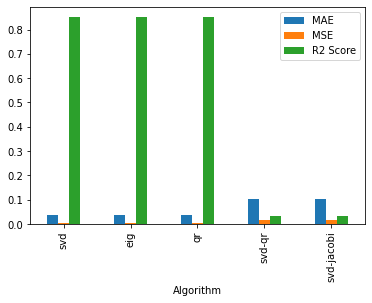

In [38]:
import pandas
models = pd.DataFrame(columns=["Algorithm","MAE","MSE","R2 Score"])
algorithm = ['svd', 'eig', 'qr', 'svd-qr', 'svd-jacobi']
for i in algorithm:
    lr = LinearRegression(fit_intercept = True, normalize = False, algorithm = i)
    reg = lr.fit(X_train,y_train)
    preds=lr.predict(X_test)
    MSE=cuml.metrics.regression.mean_squared_error(y_test,preds)
    R2_Score=cuml.metrics.regression.r2_score(y_test,preds)
    MAE=cuml.metrics.regression.mean_absolute_error(y_test,preds)
    new_row = {"Algorithm": i,"MAE": MAE, "MSE": MSE,"R2 Score": R2_Score}
    models = models.append(new_row, ignore_index=True)
models.set_index("Algorithm",inplace=True)
model=models.to_pandas()
model.plot.bar()
plt.show()
